## Random assignment, binary CATE example

This is a fully worked-out notebook showing how you would apply causaltune to a dataset.

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import warnings
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now..

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# the below checks for whether we run dowhy, causaltune, and FLAML from source
root_path = root_path = os.path.realpath('../..')
try:
    import causaltune
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))

try:
    import dowhy
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "dowhy"))

try:
    import flaml
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "FLAML"))


In [2]:
# this makes the notebook expand to full width of the browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%%javascript

// turn off scrollable windows for large output
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
from causaltune import CausalTune
from causaltune.datasets import synth_ihdp

### Model fitting & scoring
Here we fit a (selection of) model(s) to the data and score them with the energy distance metric on held-out data.

We import an example dataset and pre-process it. The pre-processing fills in the NaNs and one-hot-encodes all categorical and int variables.

If you don't want an int variable to be one-hot-encoded, please cast it to float before preprocessing.

In [5]:
# load toy dataset and apply standard pre-processing
cd = synth_ihdp()
cd.preprocess_dataset()

Inspecting the dataset below, we can see that the causal inference problem is defined by a binary `treatment`, a continuous outcome `y_factual`, and a range of covariates `x_{i}`. The `random` column is added to bypass a DoWhy bug.

In [6]:
# inspect the preprocessed dataset
display(cd.data.head())

,treatment,y_factual,random,x1,x2,x3,x4,x5,x6,x7,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,5.599916,0.0,-0.528603,-0.343455,1.128554,0.161703,-0.316603,1.295216,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,6.875856,1.0,-1.736945,-1.802002,0.383828,2.244319,-0.629189,1.295216,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2.996273,1.0,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,-0.526556,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1.366206,0.0,0.390083,0.596582,-1.850350,-0.879606,-0.004017,-0.857787,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1.963538,0.0,-1.045228,-0.602710,0.011465,0.161703,0.683672,-0.360940,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Fitting the model is as simple as calling CausalTune.fit(), with the only required parameter apart from the data being the amount of time you want to give the optimizer, either for the whole run (`time_budget`) or per FLAML component model (`components_time_budget`), or both.

If you want to use specific estimators, comment in the `estimator_list` below to include any estimators whose full name contains any of the elements of `estimator_list`.

The other allowed values are `all` and `auto`, the default is `auto`.


In [7]:
# training configs

# choose estimators of interest
estimator_list = [
            # "Dummy",
            # "SparseLinearDML",
            # "ForestDRLearner",
            # "TransformedOutcome",
            "CausalForestDML",
            # ".LinearDML",
            "DomainAdaptationLearner",
            "SLearner",
            "XLearner",
            # "TLearner",
            # "Ortho"
    ]

# set evaluation metric
metric = "energy_distance"

# it's best to specify either time_budget or components_time_budget, 
# and let the other one be inferred; time in seconds
time_budget = None
components_time_budget = 10

# specify training set size
train_size = 0.7


In [8]:
ct = CausalTune(
    estimator_list=estimator_list,
    metric=metric,
    verbose=0,
    components_verbose=0,
    time_budget=time_budget,
    components_time_budget=components_time_budget,
    train_size=train_size
)


# run causaltune
ct.fit(data=cd, outcome=cd.outcomes[0])

print('---------------------')
# return best estimator
print(f"Best estimator: {ct.best_estimator}")
# config of best estimator:
print(f"Best config: {ct.best_config}")
# best score:
print(f"Best score: {ct.best_score}")

Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Initial configs: [{'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'fit_intercept': True, 'subforest_size': 4}}]
---------------------
Best estimator: backdoor.econml.metalearners.SLearner
Best config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
Best score: 0.24818909812013867


After running a fit, you also have the option resume it without losing past results, for example if you want to search over extra estimators. To do so, simply pass `resume=True` to the `fit` method as shown below: 

`ct.fit(data=cd,outcome=cd.outcomes[0],resume=True)`

We will now score all estimators on the held-out test set and save the results per estimator in `ct.scores['test']`.

In [9]:
test_df = ct.test_df

ct.score_dataset(df=test_df, dataset_name='test')

Below we demonstrate some basic plotting functionality that comes with `causaltune`. 

In [10]:
from causaltune.visualizer import Visualizer

viz = Visualizer(
    test_df=test_df,
    treatment_col_name=cd.treatment,
    outcome_col_name=cd.outcomes[0]
)

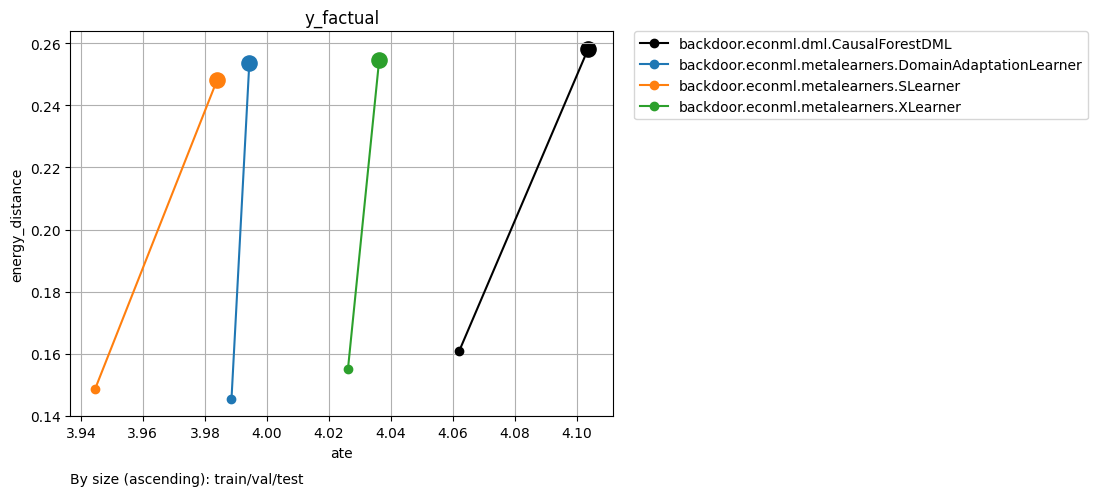

In [11]:
%matplotlib inline

# plotting metrics by estimator

figtitle = f'{viz.outcome_col_name}'
figsize = (7,5)
metrics = ('energy_distance', 'ate')

viz.plot_metrics_by_estimator(
    scores_dict=ct.scores,
    metrics=metrics,
    figtitle=figtitle,
    figsize=figsize
)

Permutation explainer: 101it [00:13,  2.30it/s]                        


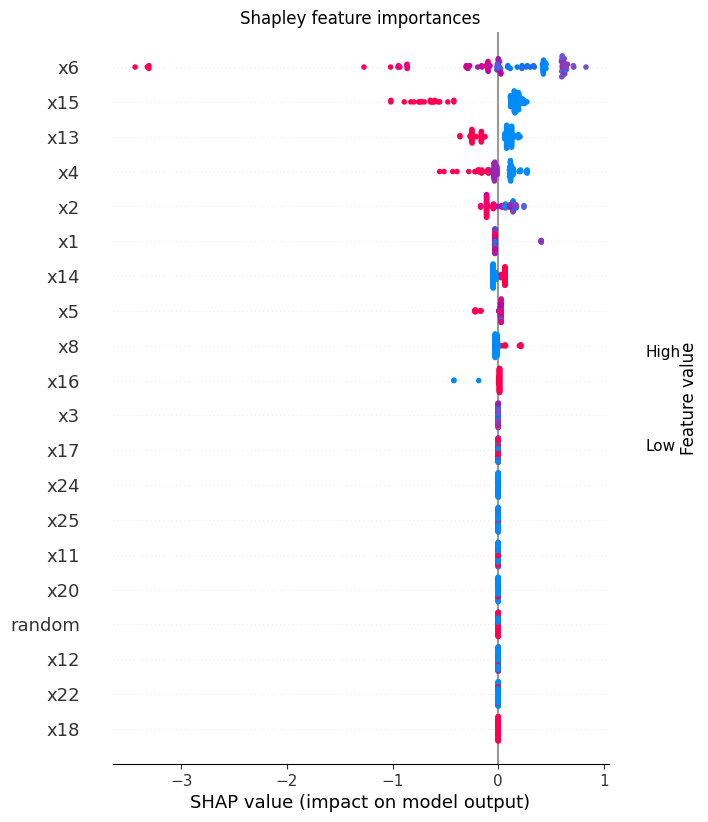

In [12]:
%matplotlib inline

# plotting shapley feature importances
# sampling from test_df as calculation can take a while
# optional: supply pre-computed shapley values by passing them as shaps=your_array

use_df = test_df.sample(100)
est = ct.model
figtitle = 'Shapley feature importances'

viz.plot_shap(
    estimate=est,
    df=use_df,
    figtitle=figtitle
)

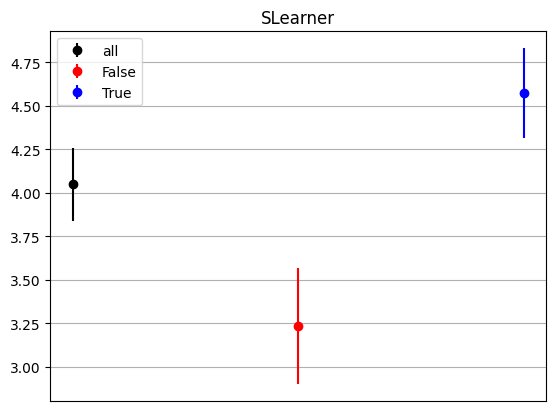

In [13]:
%matplotlib inline

# plotting out-of sample difference of outcomes between treated and untreated 
# for the points where model predicts positive vs negative impact

viz.plot_group_ate(
    scorer=ct.scorer,
    scores_dict=ct.scores,
    estimator=ct.best_estimator
)

## Custom outcome model

We also allow the user to supply a custom outcome model during training. The below example demonstrates how to use a simple linear model as outcome model. We use the same dataset as above.

Note that you can pass any arbitrary object that has `fit()` and `predict()` methods implemented to `outcome_model`. 

In [ ]:
from sklearn.linear_model import LinearRegression

ct = CausalTune(
    outcome_model=LinearRegression(),
    estimator_list=estimator_list,
    metric=metric,
    verbose=3,
    components_verbose=2,
    time_budget=time_budget,
    components_time_budget=components_time_budget,
    train_size=train_size
)


# run causaltune
ct.fit(data=cd, outcome=cd.outcomes[0])

print('---------------------')
# return best estimator
print(f"Best estimator: {ct.best_estimator}")
# config of best estimator:
print(f"Best config: {ct.best_config}")
# best score:
print(f"Best score: {ct.best_score}")